In [13]:
# Importing necessary libraries
import os
import numpy as np
from glob import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Constants/Hyperparameters
Img_Size = 256
Btch_Size = 32
Train_Imgs = 450
epochs = 100

In [4]:
# Loading data function
def load_data(image_path):
    # Read and decode image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    # Resize and normalize image
    image = tf.image.resize(image, [Img_Size, Img_Size]) / 255.0
    return image

# Data generator function
def data_generator(image_paths):
    # Create a TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    # Apply the load_data function to each element in parallel
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    # Batch and drop remainder
    dataset = dataset.batch(Btch_Size, drop_remainder=True)
    return dataset

In [5]:
# Data paths
train_low_light_images = sorted(glob("/content/drive/MyDrive/Datasets/lol_dataset/training/low/*"))[:Train_Imgs]
val_low_light_images = sorted(glob("/content/drive/MyDrive/Datasets/lol_dataset/training/low/*"))[Train_Imgs:]
test_low_light_images = sorted(glob("/content/drive/MyDrive/Datasets/lol_dataset/testing/low/*"))
train_dataset = data_generator(train_low_light_images)
val_dataset = data_generator(val_low_light_images)

In [6]:
# Building a Deep Convolutional Encoder (DCE) network
def build_dce_net():

    # Architecture of the DCE network using Keras with 6 convolutions layer

    input_img = keras.Input(shape=[None, None, 3])
    conv1 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(input_img)
    conv2 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv1)
    conv3 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv2)
    conv4 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(conv3)
    int_con1 = layers.Concatenate(axis=-1)([conv4, conv3])
    conv5 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con1)
    int_con2 = layers.Concatenate(axis=-1)([conv5, conv2])
    conv6 = layers.Conv2D(
        32, (3, 3), strides=(1, 1), activation="relu", padding="same"
    )(int_con2)
    int_con3 = layers.Concatenate(axis=-1)([conv6, conv1])
    x_r = layers.Conv2D(24, (3, 3), strides=(1, 1), activation="tanh", padding="same")(
        int_con3
    )
    return keras.Model(inputs=input_img, outputs=x_r)

In [7]:
# Custom Loss functions
def color_constancy_loss(x):
    mean_rgb = tf.reduce_mean(x, axis=(1, 2), keepdims=True)
    mr, mg, mb = mean_rgb[:, :, :, 0], mean_rgb[:, :, :, 1], mean_rgb[:, :, :, 2]
    d_rg = tf.square(mr - mg)
    d_rb = tf.square(mr - mb)
    d_gb = tf.square(mb - mg)
    return tf.sqrt(tf.square(d_rg) + tf.square(d_rb) + tf.square(d_gb))

def exposure_loss(x, mean_val=0.6):
    x = tf.reduce_mean(x, axis=3, keepdims=True)
    mean = tf.nn.avg_pool2d(x, ksize=16, strides=16, padding="VALID")
    return tf.reduce_mean(tf.square(mean - mean_val))

def illumination_smoothness_loss(x):
    batch_size = tf.shape(x)[0]
    h_x = tf.shape(x)[1]
    w_x = tf.shape(x)[2]
    count_h = (tf.shape(x)[2] - 1) * tf.shape(x)[3]
    count_w = tf.shape(x)[2] * (tf.shape(x)[3] - 1)
    h_tv = tf.reduce_sum(tf.square((x[:, 1:, :, :] - x[:, : h_x - 1, :, :])))
    w_tv = tf.reduce_sum(tf.square((x[:, :, 1:, :] - x[:, :, : w_x - 1, :])))
    batch_size = tf.cast(batch_size, dtype=tf.float32)
    count_h = tf.cast(count_h, dtype=tf.float32)
    count_w = tf.cast(count_w, dtype=tf.float32)
    return 2 * (h_tv / count_h + w_tv / count_w) / batch_size

In [8]:
# Class of custom Spatial Loss
class SpatialConsistencyLoss(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(reduction="none")

        self.left_kernel = tf.constant(
            [[[[0, 0, 0]], [[-1, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.right_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, -1]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.up_kernel = tf.constant(
            [[[[0, -1, 0]], [[0, 1, 0]], [[0, 0, 0]]]], dtype=tf.float32
        )
        self.down_kernel = tf.constant(
            [[[[0, 0, 0]], [[0, 1, 0]], [[0, -1, 0]]]], dtype=tf.float32
        )

    def call(self, y_true, y_pred):

        original_mean = tf.reduce_mean(y_true, 3, keepdims=True)
        enhanced_mean = tf.reduce_mean(y_pred, 3, keepdims=True)
        original_pool = tf.nn.avg_pool2d(
            original_mean, ksize=4, strides=4, padding="VALID"
        )
        enhanced_pool = tf.nn.avg_pool2d(
            enhanced_mean, ksize=4, strides=4, padding="VALID"
        )

        d_original_left = tf.nn.conv2d(
            original_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_right = tf.nn.conv2d(
            original_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_up = tf.nn.conv2d(
            original_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_original_down = tf.nn.conv2d(
            original_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_enhanced_left = tf.nn.conv2d(
            enhanced_pool, self.left_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_right = tf.nn.conv2d(
            enhanced_pool, self.right_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_up = tf.nn.conv2d(
            enhanced_pool, self.up_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )
        d_enhanced_down = tf.nn.conv2d(
            enhanced_pool, self.down_kernel, strides=[1, 1, 1, 1], padding="SAME"
        )

        d_left = tf.square(d_original_left - d_enhanced_left)
        d_right = tf.square(d_original_right - d_enhanced_right)
        d_up = tf.square(d_original_up - d_enhanced_up)
        d_down = tf.square(d_original_down - d_enhanced_down)
        return d_left + d_right + d_up + d_down

In [9]:
# Defining the main Zero DCE(Zero-Reference Deep Curve Estimation) model as a class with utility functions
class ZeroDCE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.dce_model = build_dce_net()

    def compile(self, learning_rate, **kwargs):
        super().compile(**kwargs)
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
        self.spatial_constancy_loss = SpatialConsistencyLoss(reduction="none")
        self.ssim_metric = keras.metrics.Mean(name="ssim")
        self.psnr_metric = keras.metrics.Mean(name="psnr")

    def get_enhanced_image(self, data, output):
        r1 = output[:, :, :, :3]
        r2 = output[:, :, :, 3:6]
        r3 = output[:, :, :, 6:9]
        r4 = output[:, :, :, 9:12]
        r5 = output[:, :, :, 12:15]
        r6 = output[:, :, :, 15:18]
        r7 = output[:, :, :, 18:21]
        r8 = output[:, :, :, 21:24]
        x = data + r1 * (tf.square(data) - data)
        x = x + r2 * (tf.square(x) - x)
        x = x + r3 * (tf.square(x) - x)
        enhanced_image = x + r4 * (tf.square(x) - x)
        x = enhanced_image + r5 * (tf.square(enhanced_image) - enhanced_image)
        x = x + r6 * (tf.square(x) - x)
        x = x + r7 * (tf.square(x) - x)
        enhanced_image = x + r8 * (tf.square(x) - x)
        return enhanced_image

    def call(self, data):
        dce_net_output = self.dce_model(data)
        return self.get_enhanced_image(data, dce_net_output)

    def compute_losses(self, data, output):
        enhanced_image = self.get_enhanced_image(data, output)
        loss_illumination = 200 * illumination_smoothness_loss(output)
        loss_spatial_constancy = tf.reduce_mean(
            self.spatial_constancy_loss(enhanced_image, data)
        )
        loss_color_constancy = 5 * tf.reduce_mean(color_constancy_loss(enhanced_image))
        loss_exposure = 10 * tf.reduce_mean(exposure_loss(enhanced_image))
        total_loss = (
            loss_illumination
            + loss_spatial_constancy
            + loss_color_constancy
            + loss_exposure
        )

        # Update SSIM and PSNR metrics
        ssim_value = tf.image.ssim(data, enhanced_image, max_val=1.0)
        psnr_value = tf.image.psnr(data, enhanced_image, max_val=1.0)
        self.ssim_metric.update_state(ssim_value)
        self.psnr_metric.update_state(psnr_value)

        return {
            "total_loss": total_loss,
            "ssim": self.ssim_metric.result(),
            "psnr": self.psnr_metric.result(),
        }


    def train_step(self, data):
        with tf.GradientTape() as tape:
            output = self.dce_model(data)
            losses = self.compute_losses(data, output)
        gradients = tape.gradient(
            losses["total_loss"], self.dce_model.trainable_weights
        )
        self.optimizer.apply_gradients(zip(gradients, self.dce_model.trainable_weights))
        return losses

    def test_step(self, data):
        output = self.dce_model(data)
        return self.compute_losses(data, output)

    def save_weights(self, filepath, overwrite=True, save_format=None, options=None):
        self.dce_model.save_weights(
            filepath, overwrite=overwrite, save_format=save_format, options=options
        )

    def load_weights(self, filepath, by_name=False, skip_mismatch=False, options=None):
        self.dce_model.load_weights(
            filepath=filepath,
            by_name=by_name,
            skip_mismatch=skip_mismatch,
            options=options,
        )

In [10]:
# Creating an instance of the ZeroDCE model
zero_dce_model = ZeroDCE()
zero_dce_model.compile(learning_rate=1e-4)

# Model Training
history = zero_dce_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Epoch 1/100
14/14 [==============================] - 45s 600ms/step - total_loss: 5.4376 - ssim: 0.9990 - psnr: 52.5042 - val_total_loss: 5.4606 - val_ssim: 0.9995 - val_psnr: 54.0428
Epoch 2/100
14/14 [==============================] - 8s 537ms/step - total_loss: 4.7548 - ssim: 0.9993 - psnr: 53.6479 - val_total_loss: 4.8511 - val_ssim: 0.9995 - val_psnr: 54.3381
Epoch 3/100
14/14 [==============================] - 8s 544ms/step - total_loss: 4.3421 - ssim: 0.9993 - psnr: 53.1019 - val_total_loss: 4.4515 - val_ssim: 0.9993 - val_psnr: 53.4483
Epoch 4/100
14/14 [==============================] - 9s 619ms/step - total_loss: 4.0536 - ssim: 0.9991 - psnr: 51.4163 - val_total_loss: 4.1633 - val_ssim: 0.9990 - val_psnr: 51.7228
Epoch 5/100
14/14 [==============================] - 8s 579ms/step - total_loss: 3.8385 - ssim: 0.9986 - psnr: 49.3762 - val_total_loss: 3.9456 - val_ssim: 0.9984 - val_psnr: 49.8062
Epoch 6/100
14/14 [==============================] - 8s 565ms/step - total_loss: 3.6

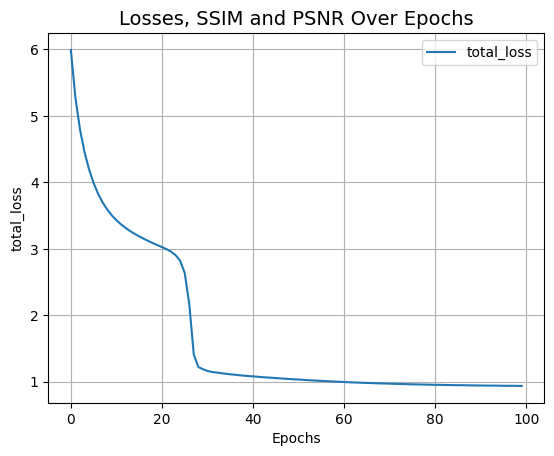

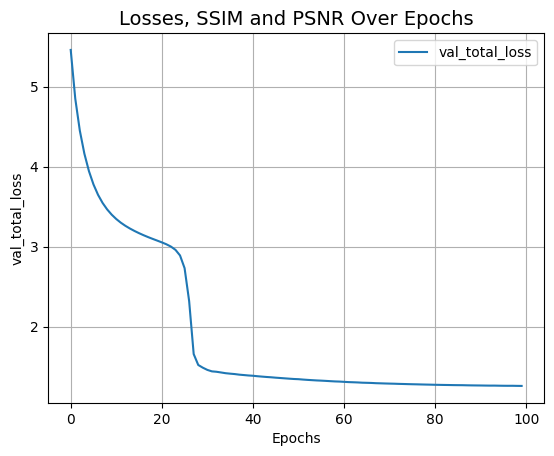

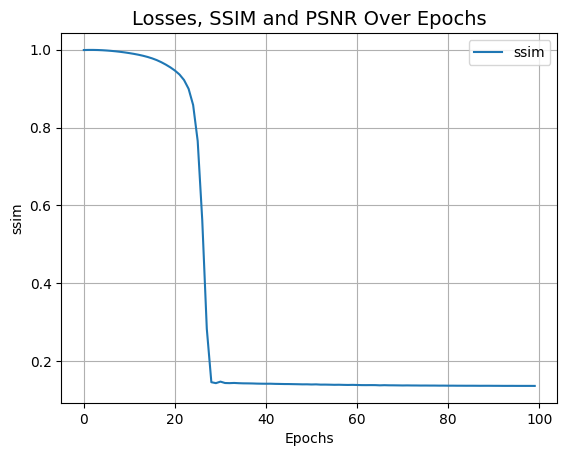

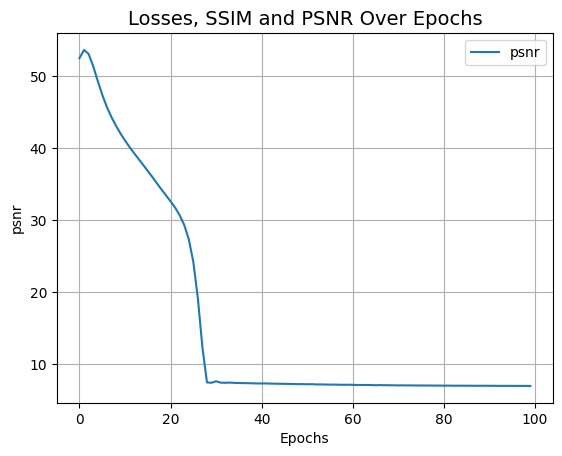

In [12]:
# Plotting history function
def plot_result(history, item):
    plt.plot(history.history[item], label=item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Losses, SSIM and PSNR Over Epochs", fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

# Plotting 'total_loss','val_total_loss', 'ssim', 'psnr'
plot_result(history, "total_loss")
plot_result(history, "val_total_loss")
plot_result(history, "ssim")
plot_result(history, "psnr")

In [14]:
# Inference function
def plot_results(images, titles, figure_size=(12, 12)):
    fig = plt.figure(figsize=figure_size)
    for i in range(len(images)):
        fig.add_subplot(1, len(images), i + 1).set_title(titles[i])
        _ = plt.imshow(images[i])
        plt.axis("off")
    plt.show()

# Inference on test images and performance evaluation
def infer(original_image):
    image = keras.utils.img_to_array(original_image)
    image = image.astype("float32") / 255.0
    image = np.expand_dims(image, axis=0)
    output_image = zero_dce_model(image)
    output_image = tf.cast((output_image[0, :, :, :] * 255), dtype=np.uint8)
    output_image = Image.fromarray(output_image.numpy())
    return output_image

<ipython-input-15-14e24e81a94e>:20: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_original = ssim(original_np, enhanced_np, multichannel=True)


SSIM (Original vs. Enhanced): 0.18454166849226275
PSNR (Original vs. Enhanced): 5.932842049550868


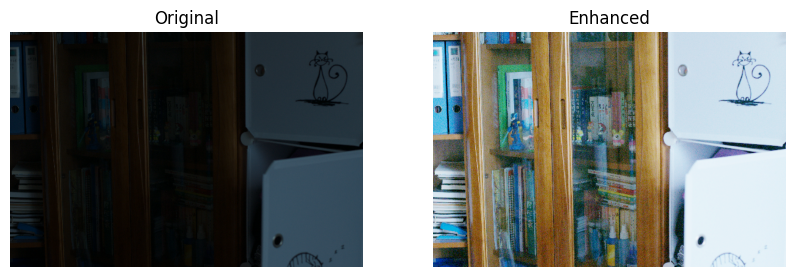


SSIM (Original vs. Enhanced): 0.16069659848923468
PSNR (Original vs. Enhanced): 4.932180960829154


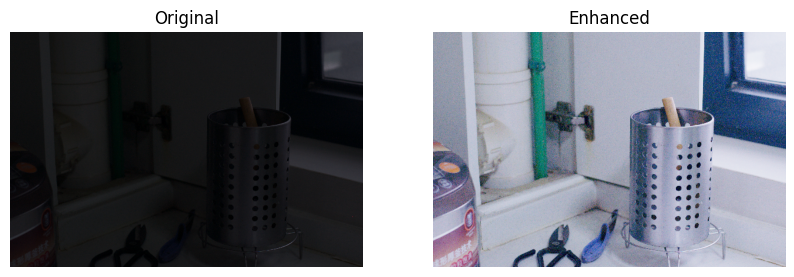


SSIM (Original vs. Enhanced): 0.20221731017349262
PSNR (Original vs. Enhanced): 4.4707592858242045


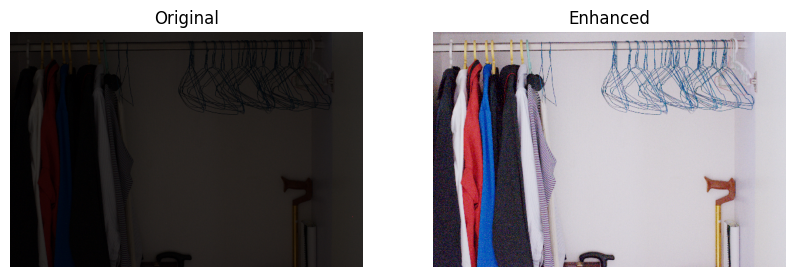


SSIM (Original vs. Enhanced): 0.16441672033502605
PSNR (Original vs. Enhanced): 4.92589119484309


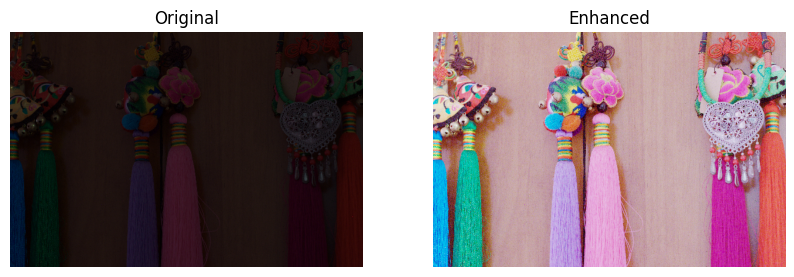


SSIM (Original vs. Enhanced): 0.16515740695481587
PSNR (Original vs. Enhanced): 5.308849189038327


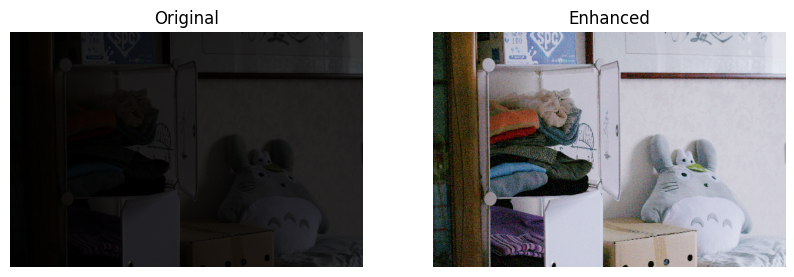


SSIM (Original vs. Enhanced): 0.09078740174135153
PSNR (Original vs. Enhanced): 7.744884763851749


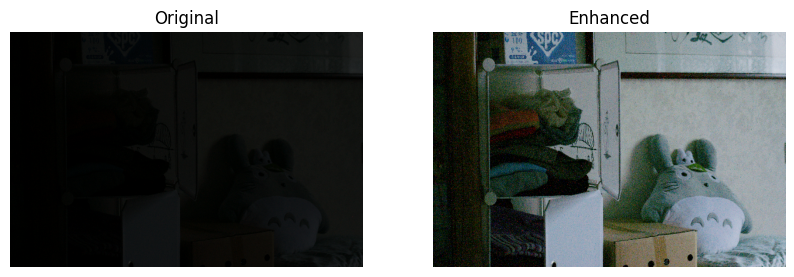


SSIM (Original vs. Enhanced): 0.12141156303902341
PSNR (Original vs. Enhanced): 9.46026251643973


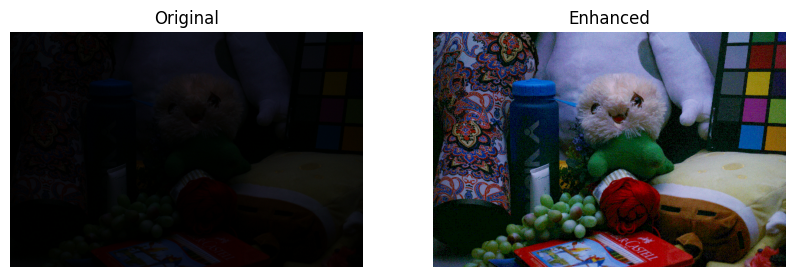


SSIM (Original vs. Enhanced): 0.12199943623182379
PSNR (Original vs. Enhanced): 5.584145562477012


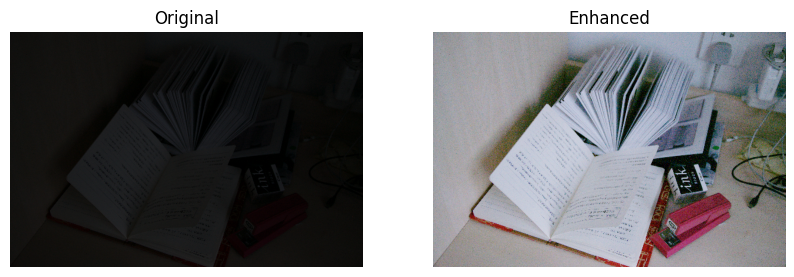


SSIM (Original vs. Enhanced): 0.09467111774920933
PSNR (Original vs. Enhanced): 7.857735377380033


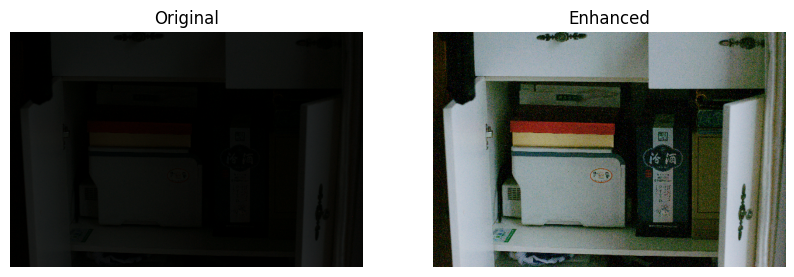


SSIM (Original vs. Enhanced): 0.06427040304862504
PSNR (Original vs. Enhanced): 8.821605218102482


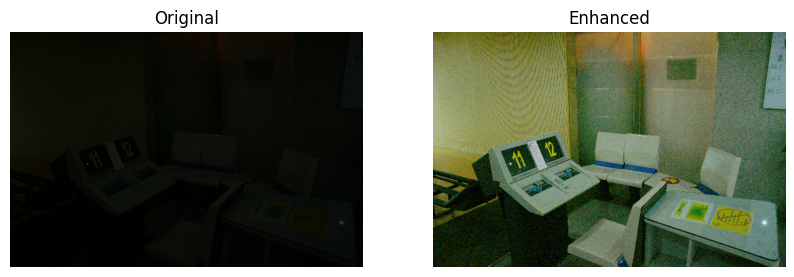


SSIM (Original vs. Enhanced): 0.13541826720447273
PSNR (Original vs. Enhanced): 5.336175185512708


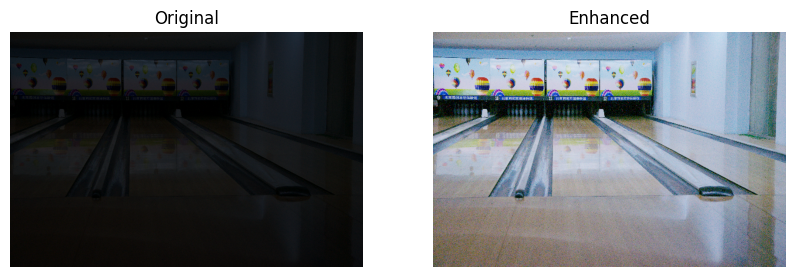


SSIM (Original vs. Enhanced): 0.08848532940494232
PSNR (Original vs. Enhanced): 6.56907825316795


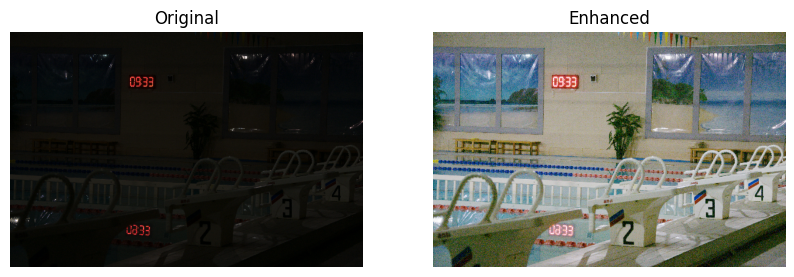


SSIM (Original vs. Enhanced): 0.0668798471308119
PSNR (Original vs. Enhanced): 9.0652879494245


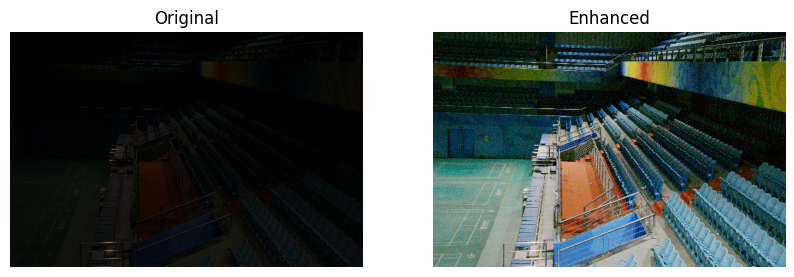


SSIM (Original vs. Enhanced): 0.08984216403159251
PSNR (Original vs. Enhanced): 7.650229838253916


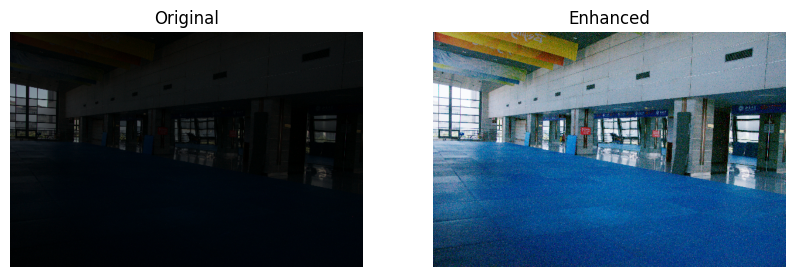


SSIM (Original vs. Enhanced): 0.18012780729478575
PSNR (Original vs. Enhanced): 4.529618433046252


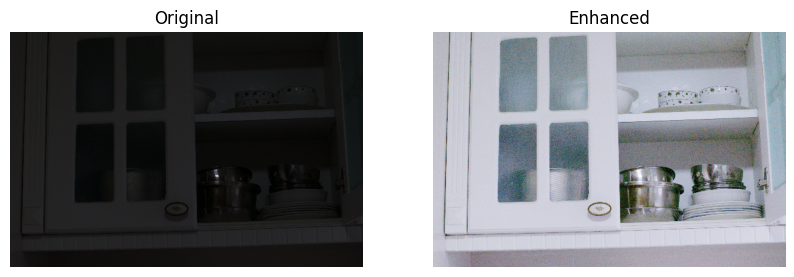

In [15]:
# Initialize lists to store SSIM and PSNR values
ssim_values = []
psnr_values = []

# Initialize counters
image_count = 0
average_ssim_original = 0
average_psnr_original = 0

# Test the model on test_low_light_images
for val_image_file in test_low_light_images:
    original_image = Image.open(val_image_file)
    enhanced_image = infer(original_image)

    # Convert images to NumPy arrays
    original_np = np.array(original_image)
    enhanced_np = np.array(enhanced_image)

    # Calculate SSIM and PSNR for Original and Enhanced images
    ssim_original = ssim(original_np, enhanced_np, multichannel=True)
    psnr_original = psnr(original_np, enhanced_np)

    # Append SSIM and PSNR values to the lists
    ssim_values.append(ssim_original)
    psnr_values.append(psnr_original)

    # Display SSIM and PSNR for the current image
    print("SSIM (Original vs. Enhanced):", ssim_original)
    print("PSNR (Original vs. Enhanced):", psnr_original)

    # Show image pairs and their SSIM and PSNR values
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(original_image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Enhanced")
    plt.imshow(enhanced_image)
    plt.axis("off")

    plt.show()

    print()

    # Update average values
    average_ssim_original += ssim_original
    average_psnr_original += psnr_original

    image_count += 1

In [16]:
# Average SSIM and PSNR values after testing
average_ssim_original /= len(test_low_light_images)
average_psnr_original /= len(test_low_light_images)

print(f"Average SSIM (Original vs. Enhanced): {average_ssim_original}")
print(f"Average PSNR (Original vs. Enhanced): {average_psnr_original}")

Average SSIM (Original vs. Enhanced): 0.12872820275476468
Average PSNR (Original vs. Enhanced): 6.545969718516131


In [17]:
from google.colab import files

# Save the model to an h5 file
h5_file_path = "/content/drive/MyDrive/Models/LOL_dce_model.h5"
zero_dce_model.save_weights(h5_file_path)

# Download the model to your local system
files.download(h5_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>